# Технический блок

Модели ETS представляют собой семейство моделей временных рядов с базовой моделью пространства состояний, состоящей из компонента уровня, компонента тренда (T), сезонного компонента (S) и члена ошибки (E).

В данном случае мы будем работать с statsmodels.
Ссылка на документацию: 
https://www.statsmodels.org/dev/examples/notebooks/generated/ets.html

## Подключение всех необходимых библиотек

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

In [2]:
plt.rcParams["figure.figsize"] = (12, 8)

## Считывание данных из CSV файла

In [3]:
data_sample = pd.read_csv('data.csv',',', index_col=['date'], parse_dates=['date'], dayfirst=True)
data_sample.head()

/var/folders/bh/08qpbz1j24sfjf29hzvdnyq80000gn/T/ipykernel_64501/3108808617.py:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  data_sample = pd.read_csv('data.csv',',', index_col=['date'], parse_dates=['date'], dayfirst=True)


,host,searches
date,,
2016-01-01,iOS,23833
2016-01-01,mobile_web,8708
2016-01-02,Android,1
2016-01-02,iOS,25793
2016-01-02,mobile_web,9012


## Создаем финальный DF, куда мы будем подгружать все спрогнозированные данные

In [4]:
All_data_forecast = pd.DataFrame()

# iOS Анализ

Я буду анализировать данные по каждому хосту отдельно.
Подробные комментарии я оставлю только к анализу iOS хоста. Следующие шаги делаются абсолютно также по аналогии.

In [5]:
data_sample_iOS = data_sample[data_sample["host"] == 'iOS']
data_sample_iOS = data_sample_iOS.resample('W').sum()
data_sample_iOS = data_sample_iOS[data_sample_iOS.index >='2016-01-10']
data_sample_iOS = data_sample_iOS[data_sample_iOS.index <='2018-12-30']

/var/folders/bh/08qpbz1j24sfjf29hzvdnyq80000gn/T/ipykernel_64501/2595747128.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_sample_iOS = data_sample_iOS.resample('W').sum()


In [6]:
iOS = pd.Series(data_sample_iOS["searches"], index=data_sample_iOS.index)

Text(0, 0.5, 'Searches iOS')

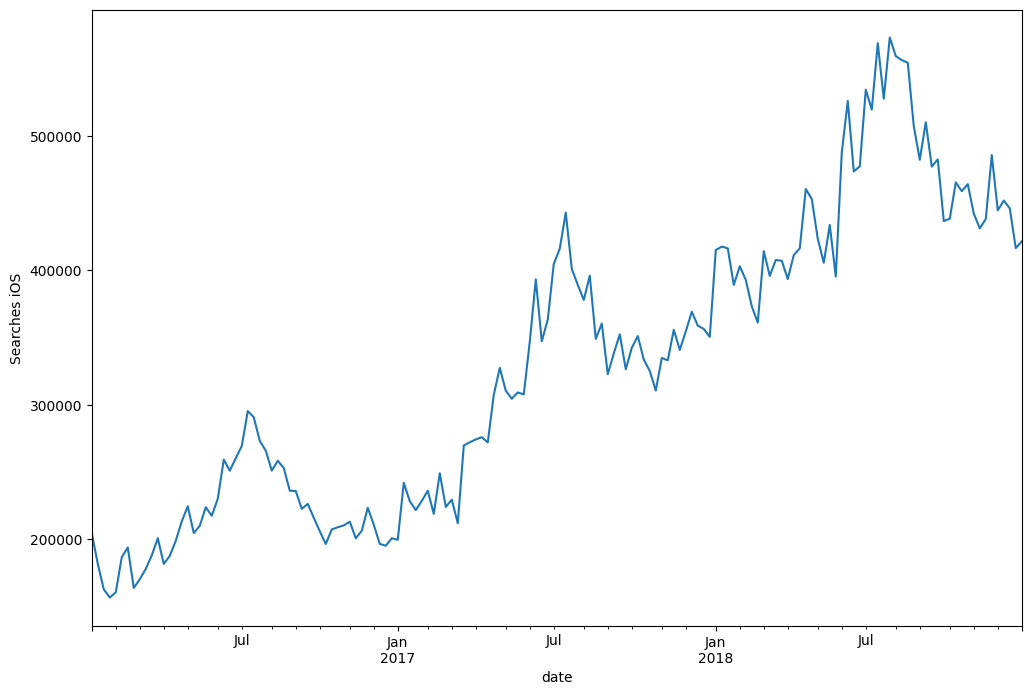

In [7]:
iOS.plot()
plt.ylabel("Searches iOS")

В аддитивном методе Холта-Уинтерса сезонный компонент добавляется к остальным. Эта модель соответствует модели ETS(A, A, A).
Я использую ETS statsmodels для построения модели экспоненциального сглаживания.

In [8]:
model = ETSModel(
    iOS,
    error="add",
    trend="add",
    seasonal="add",
    damped_trend=True,
    seasonal_periods=52,
)
fit = model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           57     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  1.18773D+01    |proj g|=  6.34052D-01

At iterate    1    f=  1.16932D+01    |proj g|=  3.03514D-01

At iterate    2    f=  1.16386D+01    |proj g|=  1.63394D-01

At iterate    3    f=  1.16068D+01    |proj g|=  9.68072D-02

At iterate    4    f=  1.15944D+01    |proj g|=  8.56629D-02

At iterate    5    f=  1.15916D+01    |proj g|=  2.97382D-02

At iterate    6    f=  1.15912D+01    |proj g|=  8.02096D-03

At iterate    7    f=  1.15912D+01    |proj g|=  8.26716D-04

At iterate    8    f=  1.15912D+01    |proj g|=  2.29150D-05

At iterate    9    f=  1.15912D+01    |proj g|=  2.30929D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

Полученные значения и реальные данные отрисуем на одном графике, чтобы можно было наглядно сравнить.

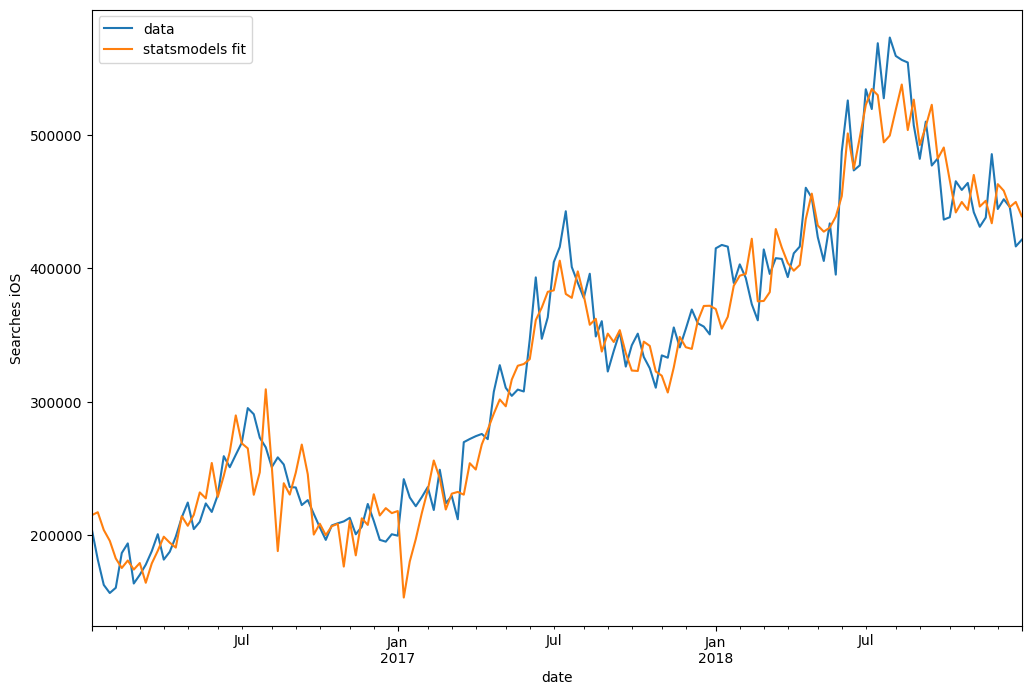

In [9]:
iOS.plot(label="data")
plt.ylabel("Searches iOS")

fit.fittedvalues.plot(label="statsmodels fit")
plt.legend()

In [10]:
print(fit.summary())

                                 ETS Results                                  
Dep. Variable:               searches   No. Observations:                  156
Model:                      ETS(AAdA)   Log Likelihood               -1808.225
Date:                Sun, 18 Dec 2022   AIC                           3734.450
Time:                        11:55:30   BIC                           3914.392
Sample:                    01-10-2016   HQIC                          3807.535
                         - 12-30-2018   Scale                    684704432.897
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.4067        nan        nan        nan         nan         nan
smoothing_trend      4.067e-05      0.005      0.008      0.994      -0.010       0.010
smoothing_season

Модель ETS также может быть использована для прогнозирования. Доступно несколько различных методов: 
1. forecast: делает на основе выборочных прогнозов;
2. predict: прогнозы в выборке и вне выборки;
3. simulate: запускает моделирование пространства состояний;
4. get_prediction: прогнозы в выборке и вне выборки, а также интервалы прогнозирования.

Мы можем использовать их в нашей ранее установленной модели для прогнозирования до 2020 года.

In [11]:
pred = fit.get_prediction(start="2016-01-10", end="2019-12-31")

In [12]:
df = pred.summary_frame(alpha=0.05)
df

,mean,pi_lower,pi_upper
2016-01-10,215079.452829,163793.354485,266365.551173
2016-01-17,217322.302922,166036.204578,268608.401266
2016-01-24,204019.291515,152733.193171,255305.389859
2016-01-31,195903.819390,144617.721046,247189.917734
2016-02-07,182682.145925,131396.047581,233968.244269
...,...,...,...
2019-12-08,431148.037286,277744.585283,584551.489289
2019-12-15,425346.431709,270530.044231,580162.819187
2019-12-22,409315.395613,253098.851744,565531.939482
2019-12-29,421503.183937,263898.922174,579107.445700


In [13]:
simulated = fit.simulate(anchor="end", nsimulations=17, repetitions=100)

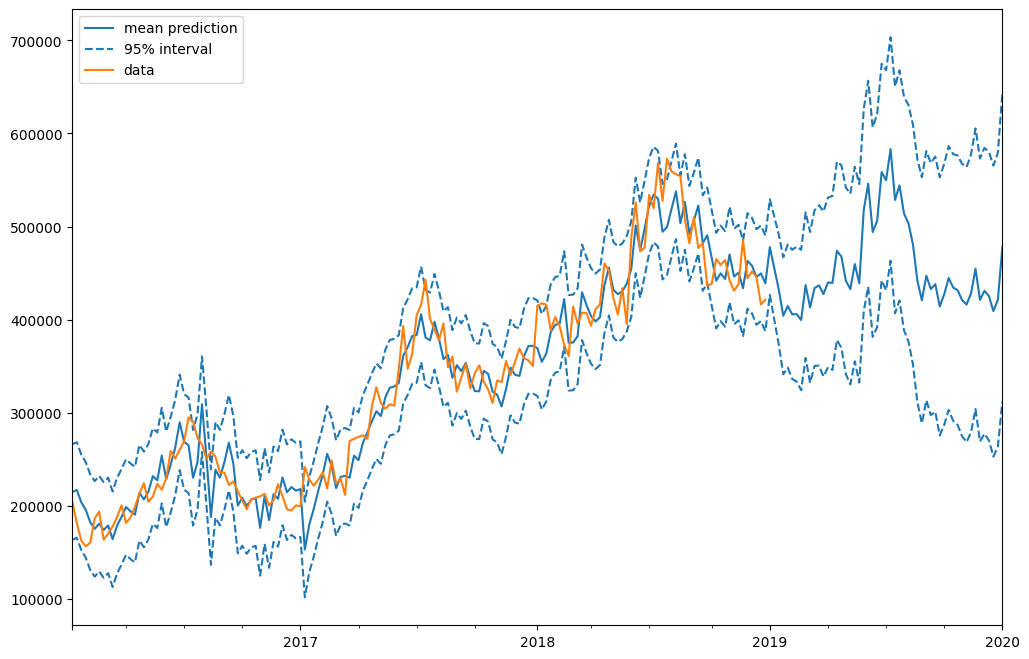

In [14]:
df["mean"].plot(label="mean prediction")
df["pi_lower"].plot(linestyle="--", color="tab:blue", label="95% interval")
df["pi_upper"].plot(linestyle="--", color="tab:blue", label="_")
pred.endog.plot(label="data")
plt.legend()

In [15]:
simulated

,simulation.0,simulation.1,simulation.2,simulation.3,simulation.4,simulation.5,simulation.6,simulation.7,simulation.8,simulation.9,...,simulation.90,simulation.91,simulation.92,simulation.93,simulation.94,simulation.95,simulation.96,simulation.97,simulation.98,simulation.99
2019-01-06,471333.614647,476572.547940,460650.783688,486028.986092,480388.871514,501746.922302,477490.908141,441613.495627,509361.235703,474326.037593,...,506853.551075,510436.409513,511016.914617,483787.073851,489730.143986,484092.268392,466549.729045,483525.239272,472604.951007,500605.671138
2019-01-13,494126.056086,481841.419568,432329.227001,475070.115541,498904.051952,501894.932564,407712.998341,424918.140431,456204.023911,448873.758721,...,435988.652637,480339.338246,476846.359102,468195.660333,418070.232164,428729.081169,453474.610019,439967.152985,455559.140722,476970.234675
2019-01-20,436734.196293,452570.368085,406101.080228,453280.345470,421569.961994,515263.972645,443550.303769,402618.746812,394338.698678,402879.127900,...,465090.381478,419454.150294,460917.927660,412050.602470,400001.423279,437038.802006,461373.286045,448499.084524,415628.260661,453340.859107
2019-01-27,410744.564209,392306.921741,385332.990435,435024.060786,411643.516319,479350.166454,396634.330704,400991.722283,357346.100003,386696.339303,...,371166.754081,384704.950087,422772.618810,372010.863313,416831.051639,409112.233132,431948.170315,434062.325970,422736.418510,405683.573671
2019-02-03,459992.613617,393020.359784,420082.132756,453020.153057,470584.435302,464434.299304,388553.957867,403548.770085,378051.622869,386216.965601,...,383393.239605,389794.500312,468678.645186,403947.957423,399800.186241,431831.021815,413709.666482,399520.671835,380400.104615,401334.853914
2019-02-10,404083.678789,449194.898091,418822.135736,428168.000464,489405.827598,434871.654776,377161.888436,418884.868930,361304.404252,393174.227873,...,437881.013355,424269.076509,413608.544495,397368.864481,399805.359991,407132.223758,432659.253285,467336.995675,400586.569133,421055.776287
2019-02-17,394200.722620,410869.966461,417701.029065,396154.241206,407200.405542,400803.343305,384060.071628,414013.085580,342212.300674,409815.316943,...,424949.999347,416901.445788,435872.730112,389688.546389,428762.286250,431046.249047,429565.641304,423560.914755,403280.821620,437348.898034
2019-02-24,416156.720105,385131.231168,440752.026522,414832.451058,400892.008242,403025.811080,371448.153264,368419.289835,359445.825854,385648.857228,...,446459.351839,415411.353734,408649.553873,416707.637357,380111.127930,439714.728187,438374.153326,438390.389519,333172.950036,413562.722778
2019-03-03,435221.177291,418928.093876,466713.847093,441127.950165,469054.095908,427297.966754,396582.071602,440276.077900,385640.154772,409053.583808,...,446631.849411,440026.947649,477571.831809,432256.545165,467743.607482,475135.682112,457929.422947,467845.462336,451515.215778,474090.405153
2019-03-10,426282.806630,399558.770868,441485.013648,441614.181514,424738.347260,424615.517718,409089.790189,385848.043177,387498.125428,364575.915975,...,445778.368002,415345.591947,456402.405100,397693.494625,416513.789173,443786.764232,402168.313271,448981.668483,333625.385175,441942.942415


In [16]:
#main
temp = pd.DataFrame()
temp["iOS"]=df["mean"]

temp = temp[temp.index >= '2019-01-06']

All_data_forecast["iOS"]=temp["iOS"]

temp = pd.DataFrame()

#pi_lower
temp = pd.DataFrame()
temp["iOS_pi_lower"]=df["pi_lower"]

temp = temp[temp.index >= '2019-01-06']

All_data_forecast["iOS_pi_lower"]=temp["iOS_pi_lower"]

temp = pd.DataFrame()

#pi_upper
temp = pd.DataFrame()
temp["iOS_pi_upper"]=df["pi_upper"]

temp = temp[temp.index >= '2019-01-06']

All_data_forecast["iOS_pi_upper"]=temp["iOS_pi_upper"]

temp = pd.DataFrame()

# Android

In [17]:
data_sample_Android = data_sample[data_sample["host"] == 'Android']
data_sample_Android = data_sample_Android.resample('W').sum()
data_sample_Android = data_sample_Android[data_sample_Android.index >='2016-01-10']
data_sample_Android = data_sample_Android[data_sample_Android.index <='2018-12-30']

/var/folders/bh/08qpbz1j24sfjf29hzvdnyq80000gn/T/ipykernel_64501/1485784260.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_sample_Android = data_sample_Android.resample('W').sum()


In [18]:
Android = pd.Series(data_sample_Android["searches"], index=data_sample_Android.index)

Text(0, 0.5, 'Searches Android')

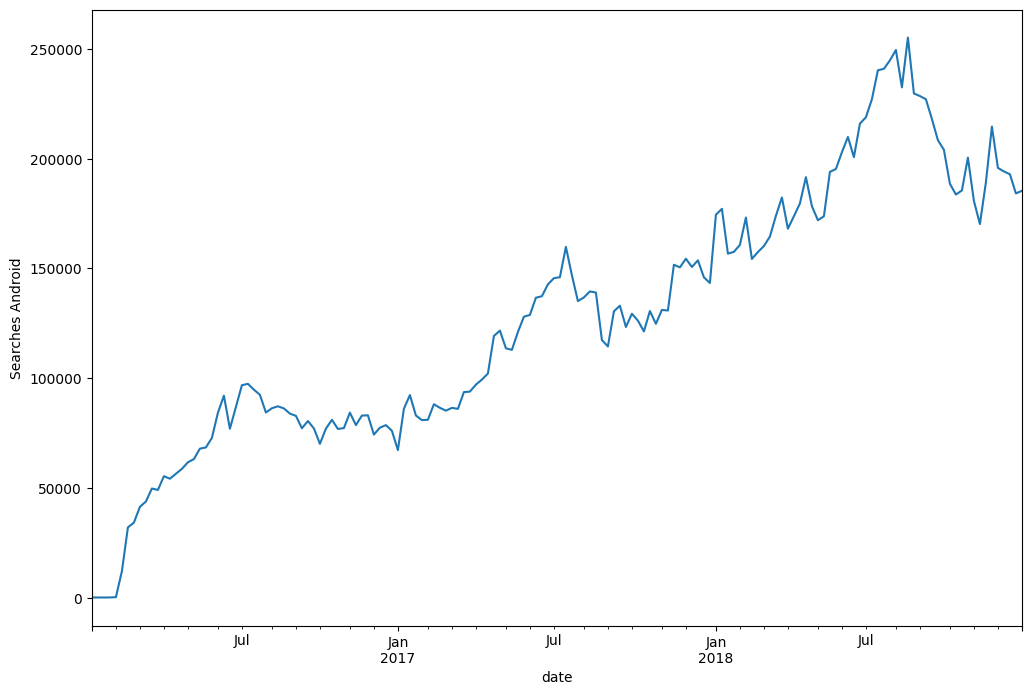

In [19]:
Android.plot()
plt.ylabel("Searches Android")

In [20]:
model = ETSModel(
    Android,
    error="add",
    trend="add",
    seasonal="add",
    damped_trend=True,
    seasonal_periods=52,
)
fit = model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           57     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  1.12265D+01    |proj g|=  8.99900D-01

At iterate    1    f=  1.08372D+01    |proj g|=  6.93701D-02

At iterate    2    f=  1.08349D+01    |proj g|=  4.60554D-02

At iterate    3    f=  1.08331D+01    |proj g|=  4.28919D-03

At iterate    4    f=  1.08330D+01    |proj g|=  3.99520D-03

At iterate    5    f=  1.08326D+01    |proj g|=  1.14934D-02

At iterate    6    f=  1.08325D+01    |proj g|=  2.49489D-03

At iterate    7    f=  1.08325D+01    |proj g|=  3.47633D-04

At iterate    8    f=  1.08324D+01    |proj g|=  3.88312D-04

At iterate    9    f=  1.08324D+01    |proj g|=  7.55840D-04

At iterate   10    f=  1.08303D+01    |proj g|=  6.39382D-03
  ys=-1.500E-02  -gs= 6.185E-05 BFGS update SKIPPED

At iterate   11    f=  1.08302D+01    |proj g|=  2.18368D-03

At iterate   12    f=  1.08297D+01  

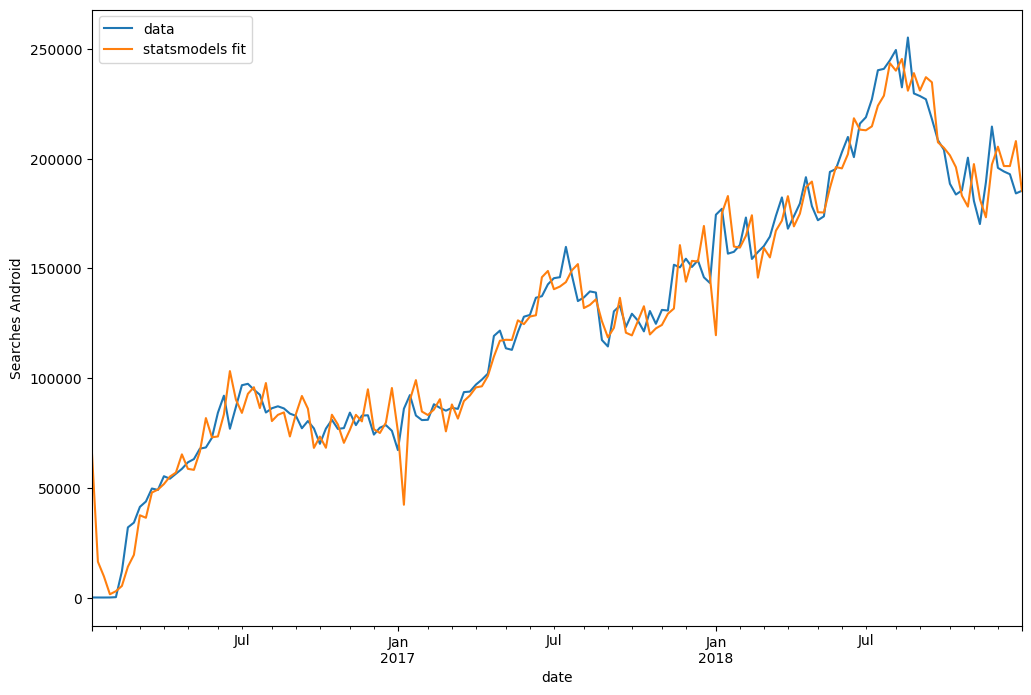

In [21]:
Android.plot(label="data")
plt.ylabel("Searches Android")

fit.fittedvalues.plot(label="statsmodels fit")
plt.legend()

In [22]:
print(fit.summary())

                                 ETS Results                                  
Dep. Variable:               searches   No. Observations:                  156
Model:                      ETS(AAdA)   Log Likelihood               -1689.428
Date:                Sun, 18 Dec 2022   AIC                           3496.856
Time:                        11:55:30   BIC                           3676.797
Sample:                    01-10-2016   HQIC                          3569.940
                         - 12-30-2018   Scale                    149298138.028
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.8778      0.127      6.886      0.000       0.628       1.128
smoothing_trend      8.778e-05      0.016      0.005      0.996      -0.032       0.032
smoothing_season

In [23]:
pred = fit.get_prediction(start="2016-01-10", end="2019-12-31")

In [24]:
df = pred.summary_frame(alpha=0.05)
df

,mean,pi_lower,pi_upper
2016-01-10,66285.887515,42337.554603,90234.220426
2016-01-17,16338.182543,-7610.150369,40286.515454
2016-01-24,9678.768815,-14269.564097,33627.101726
2016-01-31,1518.524490,-22429.808422,25466.857401
2016-02-07,2898.852452,-21049.480460,26847.185363
...,...,...,...
2019-12-08,172253.823526,24393.842673,320113.804379
2019-12-15,174325.304711,24969.241487,323681.367935
2019-12-22,188129.519496,37292.105062,338966.933930
2019-12-29,187232.648066,34928.185862,339537.110271


In [25]:
simulated = fit.simulate(anchor="end", nsimulations=17, repetitions=100)

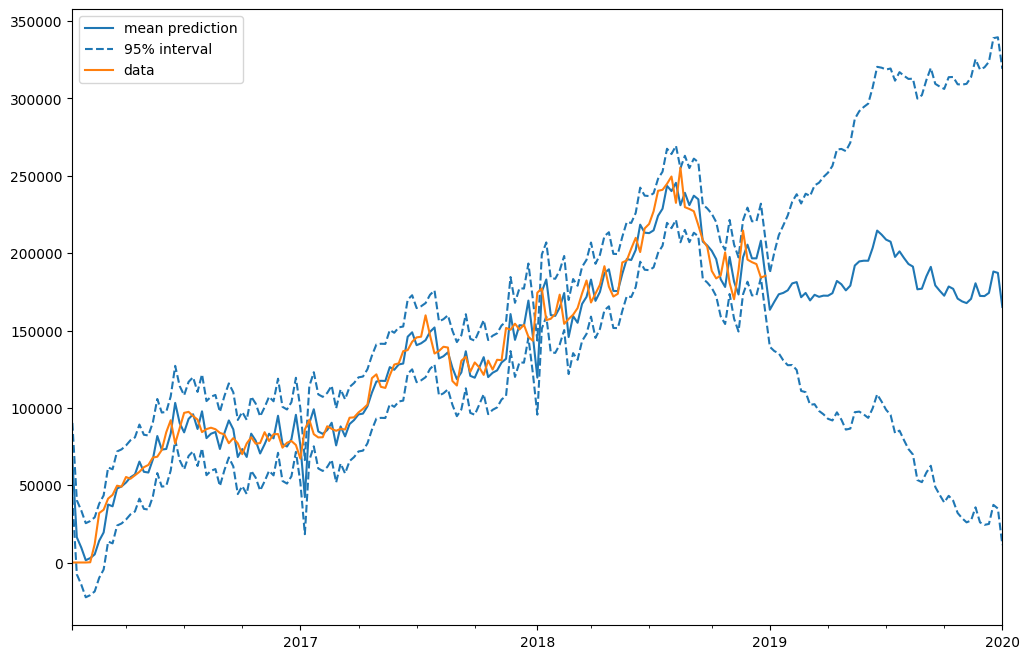

In [26]:
df["mean"].plot(label="mean prediction")
df["pi_lower"].plot(linestyle="--", color="tab:blue", label="95% interval")
df["pi_upper"].plot(linestyle="--", color="tab:blue", label="_")
pred.endog.plot(label="data")
plt.legend()

In [27]:
simulated

,simulation.0,simulation.1,simulation.2,simulation.3,simulation.4,simulation.5,simulation.6,simulation.7,simulation.8,simulation.9,...,simulation.90,simulation.91,simulation.92,simulation.93,simulation.94,simulation.95,simulation.96,simulation.97,simulation.98,simulation.99
2019-01-06,160839.193817,186303.674957,153460.209437,159825.637651,175884.011717,180354.353732,139233.670610,163500.484528,182131.981202,164656.086376,...,168248.189384,167576.513439,170947.996332,164986.163677,151784.583396,185546.699425,154957.461150,178256.702161,172234.877101,169919.186321
2019-01-13,158276.705865,199970.055812,171218.790400,199956.534192,182011.818362,215320.289308,153617.719556,195471.510869,184370.581364,141887.275983,...,170023.930957,171546.624581,178591.403782,187757.269908,158877.266630,191323.360075,149322.908719,169101.505202,198309.346512,169632.412705
2019-01-20,171821.407992,208339.469050,177958.053000,206790.928891,138869.688954,213242.916911,155699.755676,183338.673885,197033.300197,127630.357569,...,173427.790740,169495.993483,192794.888487,190862.493320,180134.709821,191266.889974,168133.864383,180026.042013,207842.093412,183690.159264
2019-01-27,177002.863613,200868.696226,167182.030209,195148.170679,140132.582772,237361.978742,165807.251771,189161.072273,193874.339287,149666.796131,...,153793.193353,177241.611748,172564.630162,175266.769907,185574.116657,208487.730508,140601.753050,183814.990369,165125.432599,176999.084134
2019-02-03,167840.886493,202179.728411,179891.503400,205530.664009,123751.434869,235299.079916,168070.017319,187038.348781,195223.054605,143857.811113,...,131059.724198,199716.394915,182922.164063,156899.552911,173285.948288,200381.758487,119105.349709,186999.362446,148318.205661,172557.170622
2019-02-10,150214.683328,221104.102881,173210.213019,209306.851075,115075.911473,243052.052507,154616.153758,171140.464680,195530.228258,146765.054170,...,144839.524164,215712.843493,162390.492969,166998.284619,166652.340104,210574.098101,138646.991441,167383.834106,155394.957004,187387.185734
2019-02-17,178577.090301,224491.023107,169570.816872,196627.724989,136090.775346,248198.952365,158412.081909,184656.360635,198864.889887,161619.877495,...,136201.697945,224855.276652,151639.309748,167432.514486,186389.962092,208757.489715,133309.437336,178291.235078,162592.377144,198138.723362
2019-02-24,163208.558257,200587.124195,164339.748692,202466.042954,130859.061890,235203.928185,145372.738240,162319.425072,166556.204439,154706.919554,...,117353.126478,199499.452463,150142.731021,154485.460137,161366.676500,201645.731528,127557.569570,146378.816125,150316.934107,185533.775021
2019-03-03,171259.637803,189217.049027,174358.169826,197797.588821,122861.843402,231775.964652,151730.394951,159946.489478,174117.622960,150455.566565,...,153227.603401,211633.868635,159274.389032,153951.853560,180262.528795,206992.461726,146730.560564,154079.709697,180560.700068,206389.086056
2019-03-10,172059.791336,163725.482964,157729.060113,228004.505293,108779.694998,233303.400640,128775.916107,171112.608360,182146.655516,149568.532781,...,156752.519818,171526.604340,146566.621169,159288.279516,151211.182994,202542.607365,139232.400668,149296.040114,171337.292056,210235.008192


In [28]:
#main
temp = pd.DataFrame()
temp["Android"]=df["mean"]

temp = temp[temp.index >= '2019-01-06']

All_data_forecast["Android"]=temp["Android"]

temp = pd.DataFrame()

#pi_lower
temp = pd.DataFrame()
temp["Android_pi_lower"]=df["pi_lower"]

temp = temp[temp.index >= '2019-01-06']

All_data_forecast["Android_pi_lower"]=temp["Android_pi_lower"]

temp = pd.DataFrame()

#pi_upper
temp = pd.DataFrame()
temp["Android_pi_upper"]=df["pi_upper"]

temp = temp[temp.index >= '2019-01-06']

All_data_forecast["Android_pi_upper"]=temp["Android_pi_upper"]

temp = pd.DataFrame()

# mobile_web

In [29]:
data_sample_mobile_web = data_sample[data_sample["host"] == 'mobile_web']
data_sample_mobile_web = data_sample_mobile_web.resample('W').sum()
data_sample_mobile_web = data_sample_mobile_web[data_sample_mobile_web.index >='2016-01-10']
data_sample_mobile_web = data_sample_mobile_web[data_sample_mobile_web.index <='2018-12-30']

/var/folders/bh/08qpbz1j24sfjf29hzvdnyq80000gn/T/ipykernel_64501/4063665501.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_sample_mobile_web = data_sample_mobile_web.resample('W').sum()


In [30]:
mobile_web = pd.Series(data_sample_mobile_web["searches"], index=data_sample_mobile_web.index)

In [31]:
mobile_web

date
2016-01-10     66684
2016-01-17     58941
2016-01-24     55863
2016-01-31     51206
2016-02-07     58720
               ...  
2018-12-02    190589
2018-12-09    189806
2018-12-16    180790
2018-12-23    173339
2018-12-30    179361
Freq: W-SUN, Name: searches, Length: 156, dtype: int64

Text(0, 0.5, 'Searches Mobile Web')

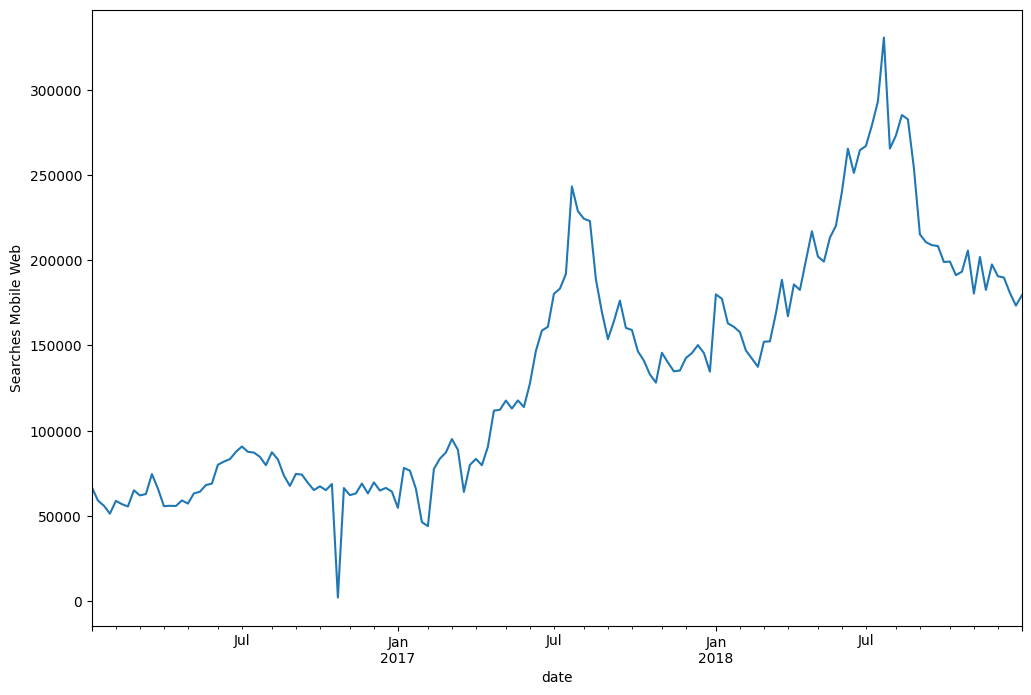

In [32]:
mobile_web.plot()
plt.ylabel("Searches Mobile Web")

In [33]:
model = ETSModel(
    mobile_web,
    error="add",
    trend="add",
    seasonal="add",
    damped_trend=True,
    seasonal_periods=52,
)
fit = model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           57     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  1.16169D+01    |proj g|=  8.99900D-01

At iterate    1    f=  1.12899D+01    |proj g|=  3.58158D-01

At iterate    2    f=  1.12540D+01    |proj g|=  2.06422D-01

At iterate    3    f=  1.12290D+01    |proj g|=  6.95721D-02

At iterate    4    f=  1.12216D+01    |proj g|=  4.78700D-02

At iterate    5    f=  1.12176D+01    |proj g|=  4.52792D-02

At iterate    6    f=  1.12140D+01    |proj g|=  2.52580D-02

At iterate    7    f=  1.12133D+01    |proj g|=  3.54490D-03

At iterate    8    f=  1.12133D+01    |proj g|=  3.60600D-05

At iterate    9    f=  1.12133D+01    |proj g|=  1.59859D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

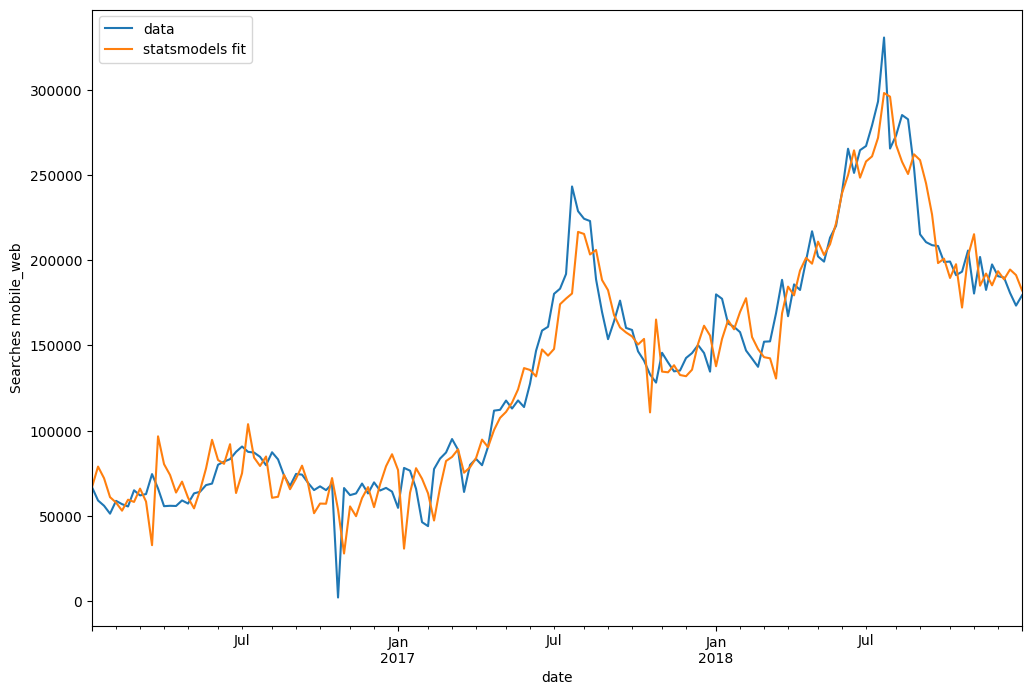

In [34]:
mobile_web.plot(label="data")
plt.ylabel("Searches mobile_web")

fit.fittedvalues.plot(label="statsmodels fit")
plt.legend()

In [35]:
print(fit.summary())

                                 ETS Results                                  
Dep. Variable:               searches   No. Observations:                  156
Model:                      ETS(AAdA)   Log Likelihood               -1749.273
Date:                Sun, 18 Dec 2022   AIC                           3616.546
Time:                        11:55:31   BIC                           3796.488
Sample:                    01-10-2016   HQIC                          3689.631
                         - 12-30-2018   Scale                    321562109.833
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.6048      0.287      2.105      0.035       0.042       1.168
smoothing_trend      6.048e-05      0.039      0.002      0.999      -0.077       0.077
smoothing_season

In [36]:
pred = fit.get_prediction(start="2016-01-10", end="2019-12-31")

In [37]:
df = pred.summary_frame(alpha=0.05)
df

,mean,pi_lower,pi_upper
2016-01-10,66865.511174,31719.137204,102011.885144
2016-01-17,78848.015154,43701.641184,113994.389124
2016-01-24,72009.959555,36863.585585,107156.333525
2016-01-31,60904.025504,25757.651534,96050.399474
2016-02-07,57719.238191,22572.864221,92865.612161
...,...,...,...
2019-12-08,168907.501171,17441.536978,320373.465364
2019-12-15,168191.060967,15239.464886,321142.657047
2019-12-22,171568.758452,17145.822397,325991.694506
2019-12-29,179354.810564,23474.421751,335235.199378


In [38]:
simulated = fit.simulate(anchor="end", nsimulations=17, repetitions=100)

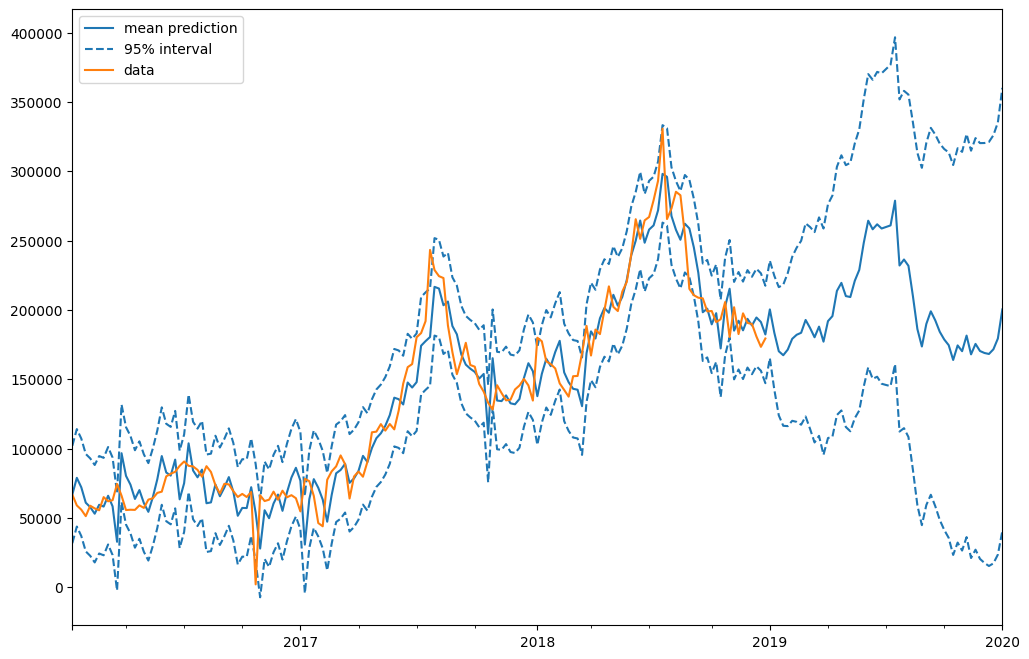

In [39]:
df["mean"].plot(label="mean prediction")
df["pi_lower"].plot(linestyle="--", color="tab:blue", label="95% interval")
df["pi_upper"].plot(linestyle="--", color="tab:blue", label="_")
pred.endog.plot(label="data")
plt.legend()

In [40]:
simulated

,simulation.0,simulation.1,simulation.2,simulation.3,simulation.4,simulation.5,simulation.6,simulation.7,simulation.8,simulation.9,...,simulation.90,simulation.91,simulation.92,simulation.93,simulation.94,simulation.95,simulation.96,simulation.97,simulation.98,simulation.99
2019-01-06,163956.561912,197466.548959,201296.684646,218518.562383,176696.683947,211738.121621,246506.936980,181596.855808,175467.040684,223078.993047,...,187772.109597,204749.039531,195192.757175,199294.021014,178014.666695,200849.745446,191340.161293,202012.323745,243250.848436,230860.273467
2019-01-13,162784.501215,178899.863374,176213.200447,202280.403019,181882.529924,192967.810294,195771.023807,138183.854163,158896.344277,203647.423380,...,180545.811349,187331.461961,175209.778859,185565.740778,167212.587533,172437.009973,166337.743830,152407.013843,205289.234703,207799.606047
2019-01-20,145017.400701,120635.141700,160681.305460,188021.918143,147328.836823,157979.698416,164080.101064,104644.636901,140153.965976,146164.272311,...,140657.401637,168466.446000,160679.294117,195361.294584,161746.199814,155453.996357,175002.685059,124289.236847,186307.982374,171385.975121
2019-01-27,108646.869156,153424.893962,171867.816691,211218.900976,133651.027022,151251.452691,187332.345107,116902.108355,148778.643365,157150.333945,...,137771.951212,166593.732501,127585.804347,165121.685990,159661.479211,169328.236148,171197.101584,109768.856131,205435.473536,186178.929025
2019-02-03,115554.204663,149111.150525,188209.995605,179682.920857,145615.818382,184532.140287,185407.021418,131296.355565,135165.882291,180277.317176,...,138870.208180,177102.076298,201194.575978,192992.560246,146299.449591,163834.708331,158835.958564,118266.318594,200437.341477,170120.573894
2019-02-10,133822.473979,176662.226390,179979.275229,200089.014288,154091.071649,162112.474285,200059.477364,139792.022282,151381.868921,162158.977193,...,151932.984273,177747.942114,140068.191032,206191.102263,115549.875770,192991.809275,196467.835596,130498.524788,194699.442344,173235.783058
2019-02-17,138627.925806,153091.792503,192843.820251,207150.397620,156839.244387,199060.771884,202784.111220,144251.613249,150159.713114,206168.815158,...,185460.539969,196897.086630,155128.952342,196584.973863,159115.678454,157588.359246,177807.201191,131302.894935,229300.807655,163331.556772
2019-02-24,147396.555537,174381.148729,162548.896251,208056.365943,149554.132131,210487.240359,207068.889557,150027.562795,145491.730285,168009.154487,...,168930.867989,216830.989472,198240.854988,196321.065673,130482.598155,174259.595734,180283.799637,126344.493497,206739.884042,168358.801286
2019-03-03,121503.406426,146540.166211,184392.748732,206856.936648,160413.224340,216467.584649,209833.725346,143817.978508,173980.963670,166035.756573,...,183683.120294,218375.613605,193057.076126,186906.493594,145246.475061,166134.635662,191828.422699,132920.156530,224840.799646,147157.098075
2019-03-10,134390.340848,129543.874568,178516.260817,190771.628995,170214.153784,225945.739137,232352.377914,170609.212385,182567.752859,128011.996609,...,212809.650941,182455.803201,214416.375315,178357.468647,140263.543755,164549.442012,201738.894339,144515.011111,199247.748880,138847.855723


In [41]:
#main
temp = pd.DataFrame()
temp["mobile_web"]=df["mean"]

temp = temp[temp.index >= '2019-01-06']

All_data_forecast["mobile_web"]=temp["mobile_web"]

temp = pd.DataFrame()

#pi_lower
temp = pd.DataFrame()
temp["mobile_web_pi_lower"]=df["pi_lower"]

temp = temp[temp.index >= '2019-01-06']

All_data_forecast["mobile_web_pi_lower"]=temp["mobile_web_pi_lower"]

temp = pd.DataFrame()

#pi_upper
temp = pd.DataFrame()
temp["mobile_web_pi_upper"]=df["pi_upper"]

temp = temp[temp.index >= '2019-01-06']

All_data_forecast["mobile_web_pi_upper"]=temp["mobile_web_pi_upper"]

temp = pd.DataFrame()

# Web

In [42]:
data_sample_web = data_sample[data_sample["host"] == 'web']
data_sample_web = data_sample_web.resample('W').sum()
data_sample_web = data_sample_web[data_sample_web.index >='2018-02-11']
data_sample_web = data_sample_web[data_sample_web.index <='2018-12-30']

/var/folders/bh/08qpbz1j24sfjf29hzvdnyq80000gn/T/ipykernel_64501/3451416481.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_sample_web = data_sample_web.resample('W').sum()


In [43]:
data_sample_web

,searches
date,
2018-02-11,349209
2018-02-18,507950
2018-02-25,490524
2018-03-04,551647
2018-03-11,455259
2018-03-18,651661
2018-03-25,716513
2018-04-01,656643
2018-04-08,676789


In [44]:
web = pd.Series(data_sample_web["searches"], index=data_sample_web.index)

Text(0, 0.5, 'Searches web')

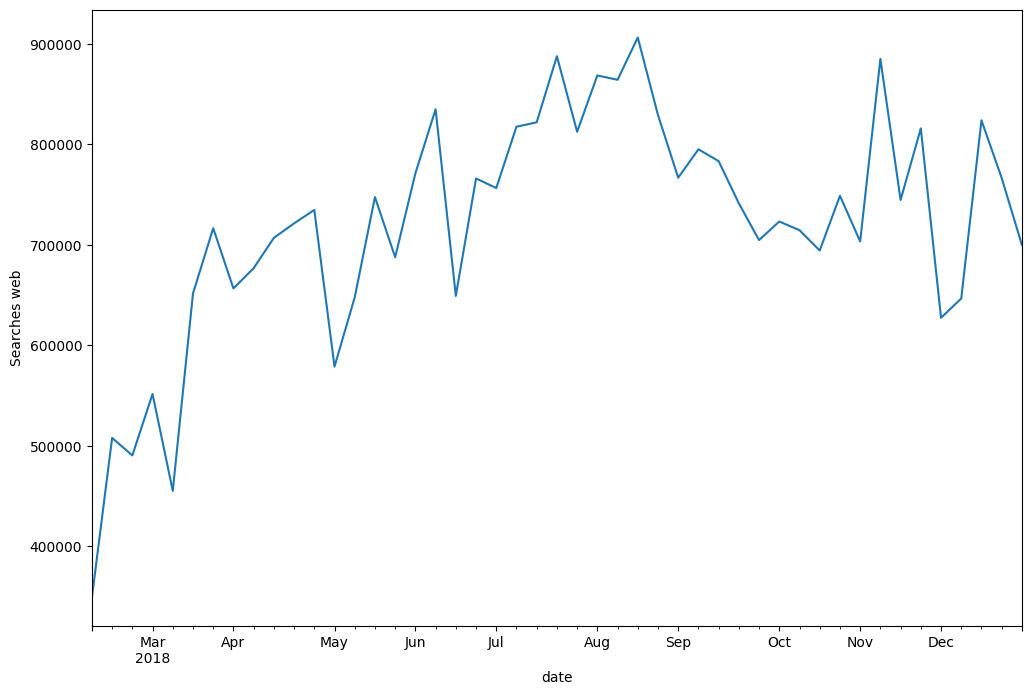

In [45]:
web.plot()
plt.ylabel("Searches web")

In [46]:
model = ETSModel(
    web,
    error="add",
    trend="add",
    seasonal="add",
    damped_trend=True,
    seasonal_periods=21,
)
fit = model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           26     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  1.31284D+01    |proj g|=  4.28883D-01

At iterate    1    f=  1.30094D+01    |proj g|=  1.43426D-01

At iterate    2    f=  1.29953D+01    |proj g|=  1.15610D-01

At iterate    3    f=  1.29830D+01    |proj g|=  7.29754D-02

At iterate    4    f=  1.29777D+01    |proj g|=  3.67596D-02

At iterate    5    f=  1.29761D+01    |proj g|=  4.62697D-02

At iterate    6    f=  1.29756D+01    |proj g|=  3.89575D-02

At iterate    7    f=  1.29751D+01    |proj g|=  2.36335D-02

At iterate    8    f=  1.29743D+01    |proj g|=  1.41856D-02

At iterate    9    f=  1.29742D+01    |proj g|=  8.96652D-03

At iterate   10    f=  1.29742D+01    |proj g|=  2.21263D-03

At iterate   11    f=  1.29742D+01    |proj g|=  1.56497D-04

At iterate   12    f=  1.29742D+01    |proj g|=  1.10134D-05

           * * *

Tit   = 

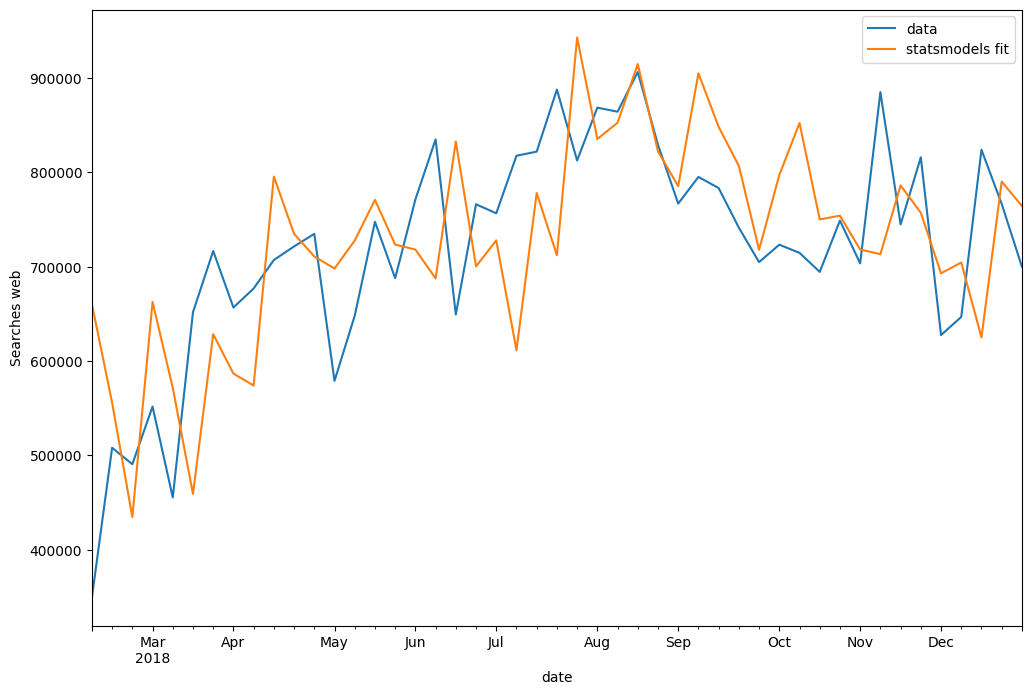

In [47]:
web.plot(label="data")
plt.ylabel("Searches web")

fit.fittedvalues.plot(label="statsmodels fit")
plt.legend()

In [48]:
print(fit.summary())

                                 ETS Results                                  
Dep. Variable:               searches   No. Observations:                   47
Model:                      ETS(AAdA)   Log Likelihood                -609.786
Date:                Sun, 18 Dec 2022   AIC                           1275.573
Time:                        11:55:32   BIC                           1327.377
Sample:                    02-11-2018   HQIC                          1295.067
                         - 12-30-2018   Scale                  10883130421.277
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.4191        nan        nan        nan         nan         nan
smoothing_trend      4.191e-05        nan        nan        nan         nan         nan
smoothing_season

In [49]:
pred = fit.get_prediction(start='2018-02-11', end="2019-12-31")

In [50]:
df = pred.summary_frame(alpha=0.05)
df

,mean,pi_lower,pi_upper
2018-02-11,660241.874162,455774.034751,8.647097e+05
2018-02-18,555660.524133,351192.684722,7.601284e+05
2018-02-25,434531.693179,230063.853767,6.389995e+05
2018-03-04,662502.293134,458034.453722,8.669701e+05
2018-03-11,571494.420615,367026.581204,7.759623e+05
...,...,...,...
2019-12-08,745313.626259,99804.379351,1.390823e+06
2019-12-15,694468.945544,43277.461950,1.345660e+06
2019-12-22,762933.408875,106108.780688,1.419758e+06
2019-12-29,832104.673073,169694.743458,1.494515e+06


In [51]:
simulated = fit.simulate(anchor="end", nsimulations=17, repetitions=100)

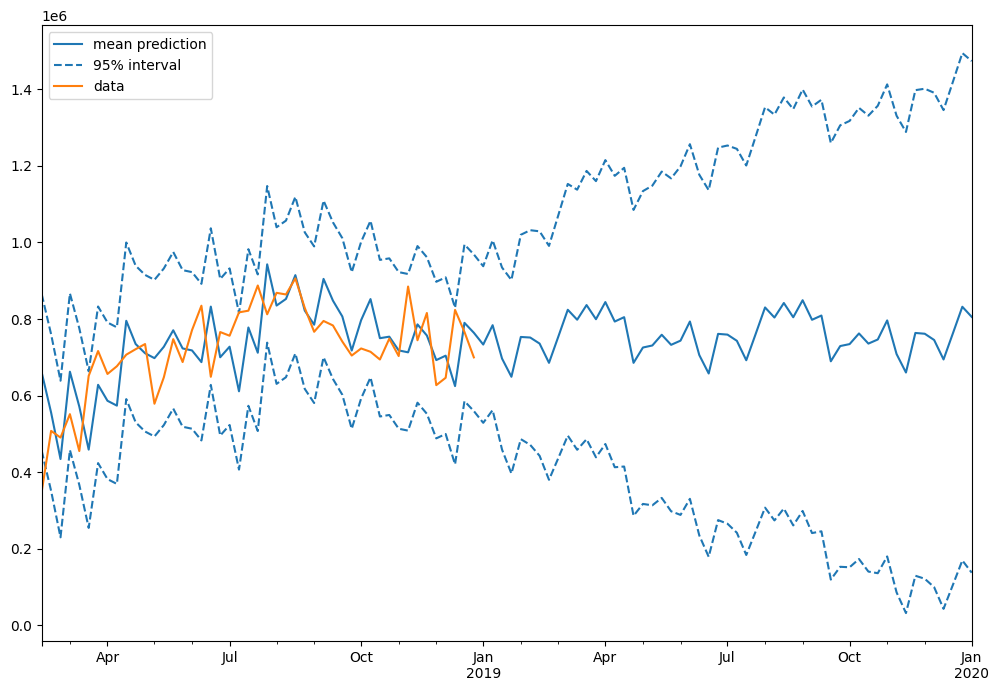

In [52]:
df["mean"].plot(label="mean prediction")
df["pi_lower"].plot(linestyle="--", color="tab:blue", label="95% interval")
df["pi_upper"].plot(linestyle="--", color="tab:blue", label="_")
pred.endog.plot(label="data")
plt.legend()

In [53]:
simulated

,simulation.0,simulation.1,simulation.2,simulation.3,simulation.4,simulation.5,simulation.6,simulation.7,simulation.8,simulation.9,...,simulation.90,simulation.91,simulation.92,simulation.93,simulation.94,simulation.95,simulation.96,simulation.97,simulation.98,simulation.99
2019-01-06,715239.680000,814888.101323,757110.500555,7.912903e+05,7.177672e+05,550780.974081,720561.584227,786816.098182,8.004900e+05,6.097286e+05,...,6.947128e+05,7.173441e+05,850779.374547,853714.005074,622637.702241,7.972769e+05,753269.661108,745068.142024,657828.824734,746002.387502
2019-01-13,832873.351070,978668.331522,636422.586909,7.972487e+05,7.785124e+05,606863.347995,835531.917018,792687.803729,8.408607e+05,1.033762e+06,...,7.695602e+05,8.273810e+05,680751.093299,731229.799122,638737.001001,9.493732e+05,655641.141406,799771.073378,648224.123779,738541.433462
2019-01-20,739460.014158,848874.432894,592551.647613,6.930704e+05,6.907912e+05,431278.257240,809648.588578,528139.615037,8.100231e+05,7.600971e+05,...,6.635484e+05,7.823746e+05,622237.428492,677568.066564,612614.002695,7.987446e+05,557586.892239,819534.777106,596627.606974,762066.372401
2019-01-27,659936.290356,861634.170916,499275.091918,6.315572e+05,7.051067e+05,521761.357046,648459.989719,492024.030719,5.496179e+05,5.587217e+05,...,7.851440e+05,7.316178e+05,496276.844217,694576.938795,611094.279181,7.224679e+05,608407.852349,611953.491980,503260.927294,719448.397204
2019-02-03,584111.559011,917956.179463,716472.636427,6.461524e+05,8.700213e+05,680551.411899,887457.047881,705965.553115,7.725457e+05,7.024514e+05,...,7.049473e+05,9.632777e+05,598904.735951,764988.424836,680309.816168,9.971251e+05,682964.229863,725132.417907,736387.023559,712831.523315
2019-02-10,558401.897346,873296.460096,620324.923682,7.475200e+05,8.300493e+05,635072.940874,846498.039802,465937.917237,7.215307e+05,7.540856e+05,...,8.674570e+05,7.992270e+05,509697.522018,660283.244123,783836.740617,9.950576e+05,633085.853318,737605.095153,697665.247183,688438.774944
2019-02-17,442127.797316,937244.759966,612943.062745,1.011018e+06,8.431618e+05,728733.237346,916854.200838,500355.942181,8.153592e+05,5.956192e+05,...,8.974326e+05,8.251130e+05,391554.067406,795612.631121,515058.071347,7.055118e+05,641441.634432,702485.440229,711783.763420,821328.193407
2019-02-24,487781.276682,758646.619716,495382.299160,7.376080e+05,7.699368e+05,469315.604867,933310.860379,508031.449824,6.106034e+05,7.293558e+05,...,8.924287e+05,7.870226e+05,435849.348994,821233.166085,645565.957666,6.524921e+05,536370.973997,432290.662520,734106.788157,709744.248384
2019-03-03,481378.624386,819440.471130,766962.242961,7.999703e+05,8.994527e+05,397915.341869,868335.870517,517083.870211,5.874295e+05,7.453929e+05,...,1.050774e+06,8.404277e+05,682799.003791,820359.822651,487398.490799,7.528288e+05,735202.533005,606325.127683,820843.650963,657394.695177
2019-03-10,617715.258959,907065.604761,591306.364691,9.709301e+05,9.538944e+05,661343.823653,914819.847037,577084.825590,1.011466e+06,9.139729e+05,...,1.095302e+06,1.002292e+06,691392.418306,868211.246161,526503.107871,8.401713e+05,951331.288047,639110.796908,797493.988633,920358.814128


In [54]:
#main
temp = pd.DataFrame()
temp["web"]=df["mean"]

temp = temp[temp.index >= '2019-01-06']

All_data_forecast["web"]=temp["web"]

temp = pd.DataFrame()

#pi_lower
temp = pd.DataFrame()
temp["web_pi_lower"]=df["pi_lower"]

temp = temp[temp.index >= '2019-01-06']

All_data_forecast["web_pi_lower"]=temp["web_pi_lower"]

temp = pd.DataFrame()

#pi_upper
temp = pd.DataFrame()
temp["web_pi_upper"]=df["pi_upper"]

temp = temp[temp.index >= '2019-01-06']

All_data_forecast["web_pi_upper"]=temp["web_pi_upper"]

temp = pd.DataFrame()

In [55]:
All_data_forecast["Total"]=All_data_forecast["iOS"]+All_data_forecast["Android"]+All_data_forecast["mobile_web"]+All_data_forecast["web"]

All_data_forecast["Total_pi_lower"]=All_data_forecast["iOS_pi_lower"]+All_data_forecast["Android_pi_lower"]+All_data_forecast["mobile_web_pi_lower"]+All_data_forecast["web_pi_lower"]

All_data_forecast["Total_pi_upper"]=All_data_forecast["iOS_pi_upper"]+All_data_forecast["Android_pi_upper"]+All_data_forecast["mobile_web_pi_upper"]+All_data_forecast["web_pi_upper"]

In [56]:
All_data_forecast

,iOS,iOS_pi_lower,iOS_pi_upper,Android,Android_pi_lower,Android_pi_upper,mobile_web,mobile_web_pi_lower,mobile_web_pi_upper,web,web_pi_lower,web_pi_upper,Total,Total_pi_lower,Total_pi_upper
2019-01-06,477973.148593,426687.050249,529259.246936,163409.598106,139461.265194,187357.931017,200347.984427,165201.610457,235494.358397,733435.427669,528967.588257,9.379033e+05,1.575166e+06,1.260318e+06,1.890015e+06
2019-01-13,454976.357624,399609.579912,510343.135336,168579.266133,136711.677532,200446.854734,183520.198353,142444.283698,224596.113009,783991.580984,562286.247349,1.005697e+06,1.591067e+06,1.241052e+06,1.941083e+06
2019-01-20,432322.891279,373155.738481,491490.044076,173420.253814,135241.088602,211599.419027,170158.642683,123906.596514,216410.688853,696872.030100,459173.224060,9.345708e+05,1.472774e+06,1.091477e+06,1.854071e+06
2019-01-27,404261.367528,341523.273577,466999.461479,174307.607396,130720.484086,217894.730705,167289.368379,116384.367972,218194.368786,649272.672527,396588.231597,9.019571e+05,1.395131e+06,9.852164e+05,1.805046e+06
2019-02-03,414743.481405,348626.762264,480860.200546,175969.919605,127574.594078,224365.245132,171323.848843,116156.617765,226491.079922,753224.782363,486392.814739,1.020057e+06,1.515262e+06,1.078751e+06,1.951773e+06
2019-02-10,405803.407654,336472.309348,475134.505960,180455.977235,127688.016539,233223.937931,179114.106593,119990.868134,238237.345052,751736.697423,471468.479280,1.032005e+06,1.517110e+06,1.055620e+06,1.978601e+06
2019-02-17,406100.430876,333697.360117,478503.501635,181288.408044,124482.720334,238094.095754,182043.548362,119212.704299,244874.392425,735968.449265,442877.523603,1.029059e+06,1.505401e+06,1.020270e+06,1.990531e+06
2019-02-24,399769.415939,324419.390225,475119.441654,171519.901274,110944.399514,232095.403035,183485.947099,117154.268657,249817.625541,685645.069117,380267.776686,9.910224e+05,1.440420e+06,9.327858e+05,1.948055e+06
2019-03-03,437184.529563,358998.452152,515370.606975,174286.836387,110162.177177,238411.495598,192739.822896,123082.925664,262396.720129,754601.753385,437412.189585,1.071791e+06,1.558813e+06,1.029656e+06,2.087970e+06
2019-03-10,413289.210018,332366.341115,494212.078922,169454.755340,101966.784757,236942.725923,186921.538967,114091.001185,259752.076750,824237.781035,495658.985444,1.152817e+06,1.593903e+06,1.044083e+06,2.143723e+06
